# Andrew Ng's Machine Learning Exercise 2b: Regularized logistic regression

In [6]:
from __future__ import division

In [7]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd # used in section 2.1
from sklearn.linear_model import LogisticRegression # used in the final section of the notebook

In [8]:
%matplotlib inline

In [9]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

In [10]:
def sns_reset(): 
    """Call this function to toggle back to the sns plotting environment from the matplotlib environment."""
    sns.reset_defaults()
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("notebook")

# Call these three functions at the top of the notebook to allow toggling between sns and matplotlib 
# environments while maintaining a uniform plot style throughout.
sns.reset_orig() 
sns_reset()
plt.ion()

# 2 Regularized logistic regression

Load the dataset.

In [11]:
data = np.loadtxt('../../data/michrochip_test.txt', delimiter=',')

In [12]:
test_1 = data[:, 0]
test_2 = data[:, 1]

M = len(test_1) 
y = data[:, 2]

## 2.1 Visualizing the data

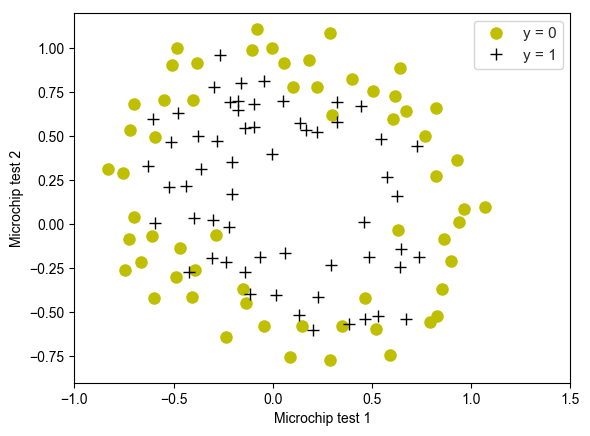

In [13]:
plt.figure()
sns.reset_orig() 
plt.plot(test_1[y == 0], test_2[y == 0], 'yo', ms=8, label='y = 0')
plt.plot(test_1[y == 1], test_2[y == 1], 'k+', ms=8, label='y = 1')
sns_reset()
plt.xlabel('Microchip test 1')
plt.ylabel('Microchip test 2')
plt.xlim(-1, 1.5)
plt.ylim(-0.9, 1.2)
plt.legend(numpoints=1, loc=1)

Visualizating the data with a seaborn plot.  The following plot is an adaption of an example in the seaborn gallery (https://stanford.edu/~mwaskom/software/seaborn/examples/scatterplot_matrix.html).  The first step is to transform the data matrix to a pandas DataFrame object.

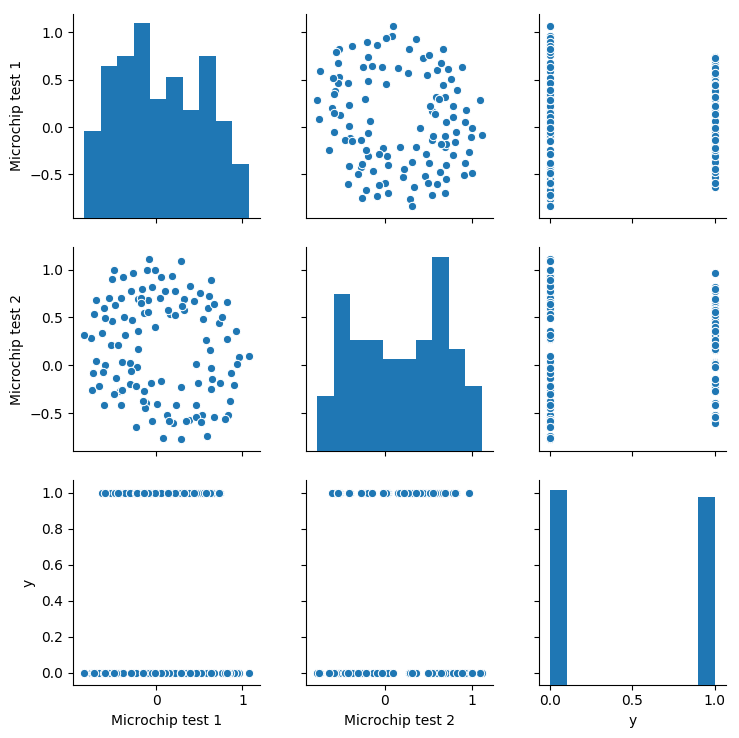

In [31]:
df = pd.DataFrame(np.vstack((test_1, test_2, y)).T, columns=['Microchip test 1', 'Microchip test 2', 'y'])
df['y'] = df['y'].astype(np.uint0)

sns.pairplot(df)

And here is an adaption of another example (https://stanford.edu/~mwaskom/software/seaborn/examples/multiple_joint_kde.html).

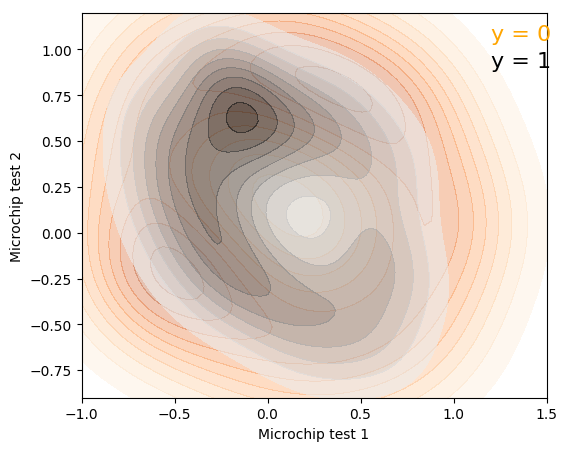

In [32]:
# Set up the figure
fig, ax = plt.subplots(figsize=(6, 5))
#ax.set_aspect('equal')
#red = sns.color_palette("Reds")[-2]
#blue = sns.color_palette("Blues")[-2]

# Draw the two density plots
ax = sns.kdeplot(test_1[y == 0], test_2[y == 0], cmap='Oranges', shade=True, shade_lowest=False, alpha=0.3)
ax = sns.kdeplot(test_1[y == 1], test_2[y == 1], cmap='Greys', shade=True, shade_lowest=False, alpha=0.6)

# Add labels to the plot
ax.set_xlabel('Microchip test 1')
ax.set_ylabel('Microchip test 2')
ax.set_xlim(-1, 1.5)
ax.set_ylim(-0.9, 1.2)
ax.text(1.2, 1.05, 'y = 0', size=16, color='orange')
ax.text(1.2, 0.90, 'y = 1', size=16, color='black');

## 2.2 Feature mapping

In [37]:
max_degree = 6

def map_feature(test_1, test_2, M):
    """Python version of mapFeature.m."""
    # Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.
    X_T = np.ones(M) 
    
    for i in range(1, max_degree+1):
        for j in range(i+1):
            X_T = np.vstack((X_T, test_1**(i-j) * test_2**j))
            
    return X_T.T

In [38]:
X = map_feature(test_1, test_2, M)

In [39]:
N = X.shape[1]

## 2.3 Cost function and gradient ($\lambda = 1$)

Set the regularization parameter.

In [40]:
lam = 1.

Inialize each of the two model parameters to zero. 

In [41]:
theta_0 = np.zeros(N)

Define the sigmoid function.

In [42]:
"""Python version of sigmoid.m."""
sigmoid = lambda x: 1 / (1 + np.exp(-x))

Define the cost function for regularized logistic regression.

In [45]:
cost_history = [] # Use this array to log costs calculated in the call to scipy's "minimize" below.

def cost_function(theta, X, y, M, lam):
    """Python version of costFunctionReg.m."""
    global cost_history
    
    cost = 1 / M * (- y.dot(np.log(sigmoid(theta.dot(X.T)))) - (1 - y).dot(np.log(1 - sigmoid(theta.dot(X.T))))) \
        + lam / 2 / M * np.sum(theta[1:]**2)
    grad = 1 / M * (sigmoid(theta.dot(X.T)) - y).dot(X) \
        + lam / M * np.array([0 if i == 0 else theta[i] for i in range(len(theta))])
    
    cost_history.append(cost)
    return cost, grad

Test it.

In [46]:
cost_0, _ = cost_function(theta_0, X, y, M, lam)

print('Cost at initial theta (zeros): %.3f' % cost_0)

Cost at initial theta (zeros): 0.693


### 2.3.1 Learning parameters using scipy's "minimize"

Run the optimization.

In [47]:
cost_history = []

"""This call to scipy's "minimize" is a Python version of the Octave call to "fminunc"."""  
res = minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y, M, lam), jac=True) 

Check the result.

In [49]:
print(res)

      fun: 0.529002733050939
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.27501637e-07,  1.61327022e-06, -3.43554528e-06,  2.52262965e-06,
       -1.63793306e-06,  3.04916733e-07, -1.53071752e-06,  7.89134815e-07,
        7.48227670e-07,  1.53297616e-06, -2.21638852e-06, -1.72275595e-06,
       -2.10000340e-06, -4.68765868e-07,  1.51882892e-06, -3.11208372e-06,
        8.12799991e-07, -1.20020852e-06, -3.11751122e-07,  2.14886656e-08,
        1.97485692e-06, -3.64732734e-06, -9.03436199e-07, -1.03273687e-06,
       -7.86536964e-07, -8.16711108e-07, -7.79763258e-07,  1.57476731e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 17
      nit: 16
   status: 0
  success: True
        x: array([ 1.27270541,  0.62540892,  1.18092128, -2.01961593, -0.9174901 ,
       -1.43172116,  0.12392317, -0.36538259, -0.35715921, -0.17496286,
       -1.45833462, -0.05113773, -0.61581145, -0.27471287, -1.19275651,
       -0.24244492, -0.205883

In [51]:
theta = res['x']

print('Cost at best-fit theta: %.3f' % res['fun'] )

Cost at best-fit theta: 0.529


Plot cost vs. steps.

In [52]:
def plot_cost_vs_steps(cost_history, file_name_suffix=''):
    num_steps = len(cost_history) 
    
    plt.figure()
    plt.scatter(np.arange(num_steps), cost_history, c='k', marker='o')
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.xlim(-num_steps * 0.05, num_steps * 1.05)
    plt.ylim(0, max(cost_history) * 1.05)

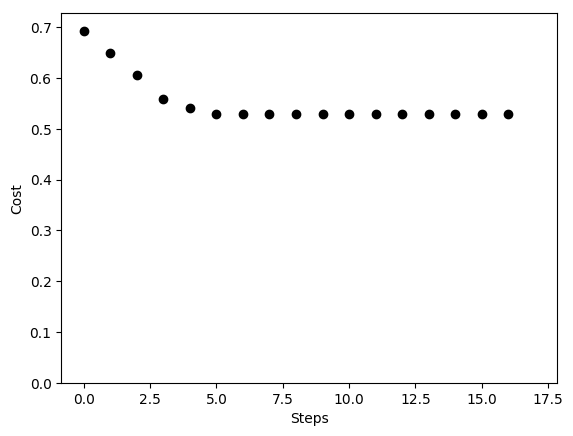

In [53]:
plot_cost_vs_steps(cost_history)

## 2.4 Plotting the decision boundary.

Calculate the value of the polynomial "$\theta^T x$" (as defined in p. 4 of ex2_orig.pdf) for the feature values contained in the arrays x_pts and y_pts.

In [60]:
def poly(theta, x_pts, y_pts):
    result = theta[0] + theta[1] * x_pts + theta[2] * y_pts - 0.5
    k = 3
    for i in range(2, max_degree+1):
        for j in range(i+1):            
            result += theta[k] * x_pts**(i-j) * y_pts**j
            k += 1
    return result

In [61]:
def plot_decision_boundary(test_1, test_2, theta, X, y, num_pts=100, file_name_suffix=''):
    """Python version of plotDecisionBoundary.m."""
    x_pts, y_pts = np.ogrid[min(test_1):max(test_1):num_pts * 1j, min(test_2):max(test_2):num_pts * 1j]
    
    plt.figure()
    sns.reset_orig()
    plt.plot(test_1[y == 0], test_2[y == 0], 'yo', ms=8, label='y = 0')
    plt.plot(test_1[y == 1], test_2[y == 1], 'k+', ms=8, label='y = 1')
    plt.contour(x_pts.ravel(), y_pts.ravel(), poly(theta, x_pts, y_pts), levels=[0])
    sns_reset()
    plt.xlabel('Microchip test 1')
    plt.ylabel('Microchip test 2')
    plt.xlim(-1, 1.5)
    plt.ylim(-0.9, 1.2)
    plt.legend(numpoints=1, loc=1)    

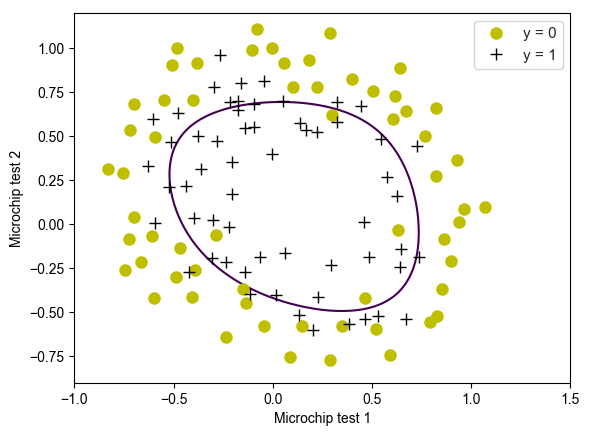

In [62]:
plot_decision_boundary(test_1, test_2, theta, X, y)

Evaluate regularized logistic regression.

In [63]:
def prediction(theta, test_1, test_2):
    """Python version of predict.m."""
    return sigmoid(poly(theta, test_1, test_2))

def accuracy(theta, test_1, test_2, y, M):
    return np.sum(np.around(prediction(theta, test_1, test_2)) == y) / M

In [64]:
print('For a microchip with test 1 and 2 scores of 0 and 0, we predict y = 1 with a probability of %.3f' \
    % prediction(theta, 0, 0))

For a microchip with test 1 and 2 scores of 0 and 0, we predict y = 1 with a probability of 0.684


In [65]:
print('Train Accuracy: %.3f' % accuracy(theta, test_1, test_2, y, M))

Train Accuracy: 0.797


## 2.5 Changes to the decision boundary as the regularization parameter is varied

Repeat the optimization and visualization steps above for cases of overfitting and underfitting.

## 2.5.1 Overfitting case ($\lambda = 0$)

In [66]:
lam = 0

In [67]:
cost_history = []

"""This call to scipy's "minimize" is a Python version of the Octave call to "fminunc"."""  
res = minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y, M, lam), jac=True) 

In [68]:
print(res)

      fun: 0.22649401614873713
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.93044751e-06,  3.84810977e-06,  9.45529421e-06, -8.69650367e-06,
        3.43875921e-06,  7.65885014e-06, -3.49363094e-06,  3.87687393e-06,
        1.81157401e-06,  3.25406364e-06, -3.57982147e-06,  3.16489966e-08,
       -2.46791301e-06,  7.73307193e-07, -1.00097866e-07, -1.87965284e-06,
       -4.26749037e-07,  1.84945253e-06,  4.49447491e-07,  7.30738977e-07,
        4.01746658e-06,  3.46748977e-06,  4.01866801e-06,  2.14347958e-06,
        3.81005109e-06, -7.19643685e-07, -1.73365104e-06,  1.11673980e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4241
      nit: 3857
   status: 0
  success: True
        x: array([   21.96845548,    31.41848658,    55.60235463,  -208.61041053,
         -96.29974953,  -106.70899786,  -203.38682708,  -452.97639956,
        -405.92574168,  -302.53773559,   675.69446301,   695.20887227,
        1064.95142432,   5

In [70]:
theta = res['x']

print('Cost at best-fit theta: %.3f' % res['fun'] )

Cost at best-fit theta: 0.226


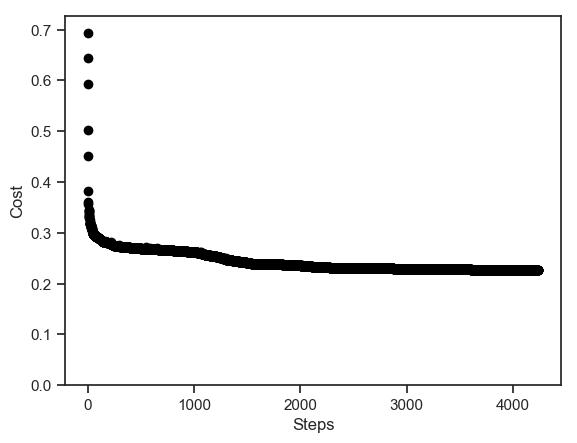

In [71]:
plot_cost_vs_steps(cost_history, file_name_suffix='_over')

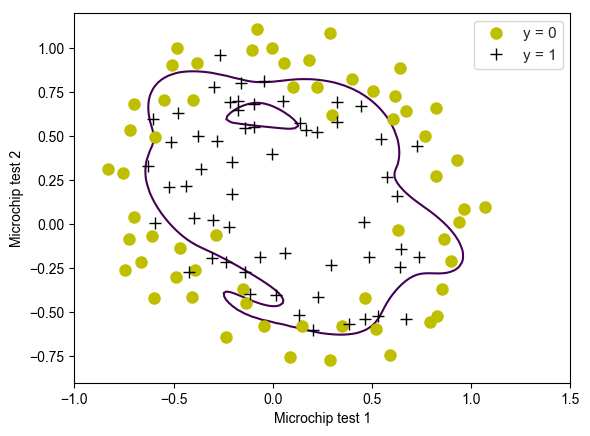

In [72]:
plot_decision_boundary(test_1, test_2, theta, X, y, file_name_suffix='_over')

In [74]:
print('For a microchip with test 1 and 2 scores of 0 and 0, we predict y = 1 with a probability of %.3f' \
    % prediction(theta, 0, 0))

For a microchip with test 1 and 2 scores of 0 and 0, we predict y = 1 with a probability of 1.000


In [75]:
print('Train Accuracy: %.3f' % accuracy(theta, test_1, test_2, y, M))

Train Accuracy: 0.890


## 2.5.2 Underfitting ($\lambda = 5$)

In [76]:
lam = 5

In [77]:
cost_history = []

"""This call to scipy's "minimize" is a Python version of the Octave call to "fminunc"."""  
res = minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y, M, lam), jac=True) 

In [78]:
print(res)

      fun: 0.6218278597351276
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.12453331e-06, -6.63892640e-06,  5.27163680e-06, -2.75290642e-06,
        9.50505709e-07,  1.15451911e-06, -2.54934168e-06, -1.28623603e-08,
       -1.88366897e-06,  4.30342529e-06, -2.94555278e-06,  5.78470924e-07,
       -1.69114855e-06,  3.30035257e-07,  1.53828735e-06, -1.77228272e-06,
       -6.66053840e-08, -7.54755689e-07, -8.30950713e-08, -8.77699182e-07,
        3.81026523e-06, -2.27200411e-06,  3.23893742e-07, -9.20783509e-07,
        1.70669212e-07, -7.09643401e-07,  8.07876433e-08,  2.47189052e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 11
      nit: 10
   status: 0
  success: True
        x: array([ 5.26753302e-01,  8.29419202e-02,  3.51703347e-01, -7.63629680e-01,
       -2.17007894e-01, -4.73416512e-01, -6.10087173e-02, -1.03773166e-01,
       -1.12798980e-01, -1.35131548e-01, -5.64129355e-01, -2.15895963e-02,
       -2.05442908e

In [79]:
theta = res['x']

print('Cost at best-fit theta: %.3f' % res['fun'] )

Cost at best-fit theta: 0.622


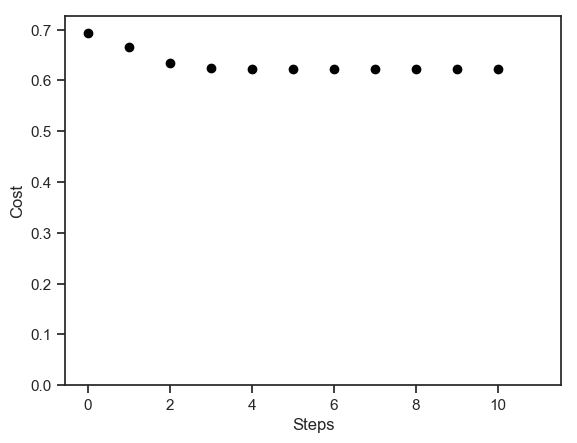

In [80]:
plot_cost_vs_steps(cost_history, file_name_suffix='_under')

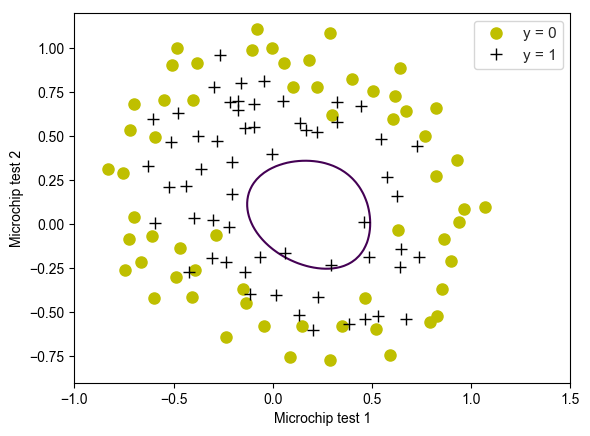

In [81]:
plot_decision_boundary(test_1, test_2, theta, X, y, file_name_suffix='_under')

In [82]:
print('For a microchip with test 1 and 2 scores of 0 and 0, we predict y = 1 with a probability of %.3f' \
    % prediction(theta, 0, 0))

For a microchip with test 1 and 2 scores of 0 and 0, we predict y = 1 with a probability of 0.507


In [83]:
print('Train Accuracy: %.3f' % accuracy(theta, test_1, test_2, y, M))

Train Accuracy: 0.534


# Regularized logistic regression with scikit-learn

The 'LogisticRegression' classifier is generated here with the regularization parameter, $C=1/\lambda$, set to '1'.  Setting 'penalty' to 'l2' specifies the use of L2 regularization.  Setting 'multi_class' to 'ovr' ('one-vs-rest') specifies the use of the cross-entropy cost function. These settings also happen to be the default parameters for the LogisticRegression classifier, so 'clf = LogisticRegression()' is equivalent to the first line below.  Note:  The data matrix, X, should have dimensions ```num_samples x num_features``` and should omit the initial column of ones.

In [84]:
clf = LogisticRegression(C=1, penalty='l2', multi_class='ovr') 
clf.fit(X[:, 1:], y) 
theta = np.hstack((clf.intercept_, clf.coef_[0]))

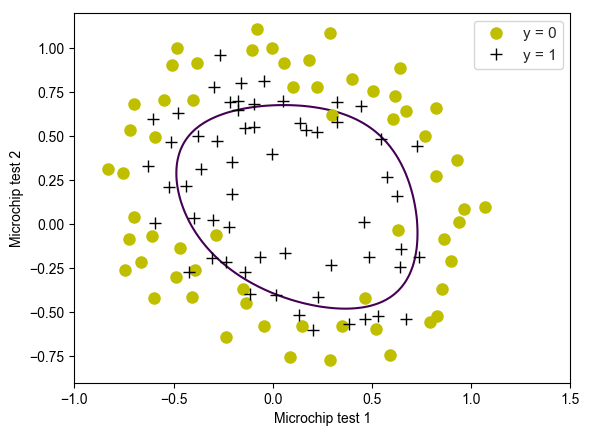

In [85]:
plot_decision_boundary(test_1, test_2, theta, X, y, file_name_suffix='_sklearn')